In [2]:
import numpy as np
import pandas as pd
import opendp.smartnoise.core as sn
import pymc3 as pm
import arviz as az
import theano.tensor as tt
import theano
from sklearn.feature_selection import mutual_info_regression
from GPyOpt.methods import BayesianOptimization
import matplotlib.pyplot as plt

In [5]:
## opendp program
def dp_program(age,sex,educ,race,income,married,N=10):
    temp_file='temp.csv'    
    var_names = ["age", "sex", "educ", "race", "income", "married"]
    data = {
        "age":     age,
        "sex":     sex,
        "educ":    educ,
        "race":    race,
        "income":  income,
        "married": married
    }
    df = pd.DataFrame(data,columns=var_names)
    df.to_csv(temp_file)
    with sn.Analysis() as analysis:
        # load data
        data = sn.Dataset(path=temp_file,column_names=var_names)

        # get mean of age
        age_mean = sn.dp_mean(data = sn.to_float(data['income']),
                              privacy_usage = {'epsilon': .1},
                              data_lower = 0., # min income
                              data_upper = 200., # max income                   
                              data_rows = N
                             )
    analysis.release()
    return np.float64(age_mean.value)    

In [6]:
age = np.random.random_integers(0, 10, (10,10_000))
sex = np.random.random_integers(0, 10, (10,10_000))
educ = np.random.random_integers(0, 10, (10,10_000))
race = np.random.random_integers(0, 10, (10,10_000))
income = np.random.normal(0, 10, (10,10_000))
married = np.random.random_integers(0, 10, (10,10_000))

out = np.empty(10_000, dtype=np.float64)
for i in range(10_000)
    out[i] = dp_program(age[:,i], sex[:,i], educ[:,i],race[:,i],income[:,i], married[:,i]) for i in range(10_000)

In [8]:
mutual_info_regression(age[0].reshape((-1,1)), out)

array([0.01054878])

In [24]:
@theano.compile.ops.as_op(itypes=[tt.dscalar,tt.dscalar],
                          otypes=[tt.dscalar])
def f_pymc3(mu,sigma):
    with pm.Model() as model:
        unique_identifier = np.random.randint(0,1_000_000)
        
        N = 10
        N_rv = pm.Constant("N"+str(unique_identifier), N)
        
        age = pm.DiscreteUniform("age"+str(unique_identifier), 0,150, shape=N)
        sex = pm.DiscreteUniform("sex"+str(unique_identifier), 0,2, shape=N)
        educ = pm.DiscreteUniform("educ"+str(unique_identifier), 0,10, shape=N)
        race = pm.DiscreteUniform("race"+str(unique_identifier), 0,50, shape=N)
        income = pm.Normal("income"+str(unique_identifier), mu, sigma, shape=N)
        married = pm.DiscreteUniform("married"+str(unique_identifier), 0,1, shape=N)
        
        pm.Deterministic("output"+str(unique_identifier),dp_program(age,sex,educ,race,income,married,N_rv))
        
        trace=pm.sample(500, return_inferencedata=False, cores=1)
        
        I = 0
        names = ["age"+str(unique_identifier), "sex"+str(unique_identifier), "educ"+str(unique_identifier), "race"+str(unique_identifier), "income"+str(unique_identifier),"married"+str(unique_identifier)]
        for n in names:
            I += mutual_info_regression(trace[n][:,0].reshape(-1,1), trace["output"+str(unique_identifier)])[0]
    return I

In [25]:
with pm.Model() as model2:
    mu = pm.Uniform("Mu", 0,100)
    sigma = pm.HalfNormal("sigma", 10)
    
    out = pm.Deterministic("out", f_pymc3(mu, sigma))
    
    t = pm.sample(100, return_inferencedata=False, cores=1)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married402027]
>>Metropolis: [race402027]
>>Metropolis: [educ402027]
>>Metropolis: [sex402027]
>>Metropolis: [age402027]
>>Metropolis: [N402027]
>NUTS: [income402027]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 31 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Only 100 samples in chain.
Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [income402027, sigma, Mu]
>CompoundStep
>>Metropolis: [married402027]
>>Metropolis: [race402027]
>>Metropolis: [educ402027]
>>Metropolis: [sex402027]
>>Metropolis: [age402027]
>>Metropolis: [N402027]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married322448]
>>Metropolis: [race322448]
>>Metropolis: [educ322448]
>>Metropolis: [sex322448]
>>Metropolis: [age322448]
>>Metropolis: [N322448]
>NUTS: [income322448]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 31 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married108137]
>>Metropolis: [race108137]
>>Metropolis: [educ108137]
>>Metropolis: [sex108137]
>>Metropolis: [age108137]
>>Metropolis: [N108137]
>NUTS: [income108137]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 31 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married500942]
>>Metropolis: [race500942]
>>Metropolis: [educ500942]
>>Metropolis: [sex500942]
>>Metropolis: [age500942]
>>Metropolis: [N500942]
>NUTS: [income500942]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 30 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married667208]
>>Metropolis: [race667208]
>>Metropolis: [educ667208]
>>Metropolis: [sex667208]
>>Metropolis: [age667208]
>>Metropolis: [N667208]
>NUTS: [income667208]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 33 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married395761]
>>Metropolis: [race395761]
>>Metropolis: [educ395761]
>>Metropolis: [sex395761]
>>Metropolis: [age395761]
>>Metropolis: [N395761]
>NUTS: [income395761]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 32 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married491338]
>>Metropolis: [race491338]
>>Metropolis: [educ491338]
>>Metropolis: [sex491338]
>>Metropolis: [age491338]
>>Metropolis: [N491338]
>NUTS: [income491338]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 31 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married550455]
>>Metropolis: [race550455]
>>Metropolis: [educ550455]
>>Metropolis: [sex550455]
>>Metropolis: [age550455]
>>Metropolis: [N550455]
>NUTS: [income550455]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 31 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married894325]
>>Metropolis: [race894325]
>>Metropolis: [educ894325]
>>Metropolis: [sex894325]
>>Metropolis: [age894325]
>>Metropolis: [N894325]
>NUTS: [income894325]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 32 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married730874]
>>Metropolis: [race730874]
>>Metropolis: [educ730874]
>>Metropolis: [sex730874]
>>Metropolis: [age730874]
>>Metropolis: [N730874]
>NUTS: [income730874]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 32 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married573320]
>>Metropolis: [race573320]
>>Metropolis: [educ573320]
>>Metropolis: [sex573320]
>>Metropolis: [age573320]
>>Metropolis: [N573320]
>NUTS: [income573320]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 30 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
Sampling 1 chain for 8 tune and 0 draw iterations (8 + 0 draws total) took 317 seconds.
No posterior samples. Unable to run convergence checks


[0. 1. 0. 1. 1. 1.]
[189.  55.  42.  12.  37.  10.]
[  6. 127. 149. 197.  73.  92.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 69 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 1. 0. 0.]
[ 78.   7.  42. 102.  76.  31.]
[128. 136. 124.  55. 136. 149.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 71 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 1. 0. 1.]
[ 37. 136.  99. 138. 180.   7.]
[105.  55. 155. 133. 128. 185.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 59 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 0. 0. 1. 1.]
[172.  11. 151.  40. 186.  88.]
[ 10. 150.  68.  98. 171. 133.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 60 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 1. 1. 1.]
[ 69. 132.  12.  97.  51. 165.]
[129. 182. 105. 107.  72.  64.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 60 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 1. 1. 0.]
[ 72. 123. 154. 106. 107.  26.]
[123.  94.  41. 170.  83. 191.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 54 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 0. 0. 1.]
[ 39. 172. 150.  42. 151. 111.]
[106. 156.  79.  49. 126. 189.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 0. 0. 1.]
[ 44.  17. 186.  90.  96.  88.]
[191. 169. 124. 120.  44.  49.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 1. 1. 0.]
[180. 130.  33. 119.   0. 189.]
[ 28. 172. 134.  98. 111. 181.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 1. 0. 1. 1.]
[ 69. 127.  51. 107.  52.  67.]
[ 28. 179.  97.  76.  47. 109.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 0. 0. 1.]
[172. 111. 191. 144. 143. 143.]
[147.   8.  60.  42. 154.  87.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 1. 0. 1. 0.]
[146.  88. 153. 177.  10.  13.]
[ 15. 154.  82.  84.  97. 174.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 1. 1. 1. 0.]
[ 63.  53.   1.  95. 196.  59.]
[176. 189.   1. 124.  89.  64.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 0. 1. 0.]
[156. 129.  34. 195.   3. 124.]
[188.  91. 184.  26. 107.  56.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 1. 0. 0.]
[ 16. 136. 100. 160.  36.  88.]
[126. 189. 194.  68. 109.  49.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 1. 1. 0.]
[114.  90.  95. 135.   1. 162.]
[186.  41.  54.   3. 127. 115.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 1. 0. 0.]
[129. 164. 141. 138. 177. 114.]
[195. 172. 166.  54.  23. 190.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 1. 1. 1.]
[ 69. 171.  80. 199.  59.  90.]
[109. 186.  66. 143. 155.  35.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 1. 1. 1.]
[116.  94.  66.  86. 111.  13.]
[110. 195.  94.  76.  60. 169.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 0. 0. 0.]
[ 35.  81. 185. 129. 157. 167.]
[192.  85.  75.  91.  67. 139.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 1. 0. 1.]
[ 66.  13. 106. 120.  18. 112.]
[136.  84.  66.  19. 192. 132.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 1. 0. 0. 0.]
[ 44. 196.  33.  92.  97. 140.]
[128.  65.  87. 107. 103.  92.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 1. 1. 1. 0.]
[123.  53.   2. 112.  30.  74.]
[118. 138.  76.  23.  27.  63.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 1. 1. 1.]
[ 86.  81. 149. 148. 132.  87.]
[169.  37.  26. 120. 135. 126.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 1. 1. 1. 0.]
[198.  79. 129.  97.  69. 192.]
[151. 165.  58. 169. 142. 119.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 1. 1. 0. 0.]
[ 60. 109. 190.  42.  11.  97.]
[ 54.  57. 158.  79. 104.  44.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 0. 1. 1.]
[123.  49.  66.  73. 190.  51.]
[137.  74. 140.  61. 166.  84.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 0. 1. 0.]
[ 71. 141.  21.  34.  66. 122.]
[ 23.  41. 151. 104.  73. 142.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 1. 0. 0. 1.]
[ 65. 199.  37.  82.   8. 117.]
[ 56.  17.  30. 103.  62. 155.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 51 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 0. 1. 0.]
[158.  48. 144.  73.  22.   7.]
[175. 181.  45.  31.  55. 153.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 0. 0. 1.]
[ 75.  95.  67.  39. 145. 147.]
[112. 114.  10.   4. 186. 142.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 47 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 0. 1. 0.]
[ 17. 156.  16. 101.   9.  94.]
[ 40.  71.  29. 179. 160.  98.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 0. 0. 1. 0.]
[ 69.   6.  31. 154. 118. 157.]
[126. 164.  22. 115.  49. 105.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 1. 1. 1.]
[100. 100.  94. 150. 103. 131.]
[ 75.  61.  10. 151. 135. 113.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 0. 1. 1.]
[152.   7.  25. 167.  94.  80.]
[180.  61. 170. 128.  94. 142.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 47 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 1. 0. 1.]
[127.  42.  84.   1. 157. 137.]
[199. 106. 155. 109.  32. 183.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 1. 0. 0.]
[152. 125. 112.  72. 193. 168.]
[ 99. 131. 181.  83.  81.  47.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 1. 1. 0.]
[177. 141. 137.   9.  73.  37.]
[102.  14. 145. 114.  98. 176.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 1. 1. 0.]
[ 33. 104. 160.  10. 145. 151.]
[158.  55.  79.  29. 104.  50.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 0. 1. 1.]
[123. 170.   1. 107.  98. 132.]
[132. 151. 178.  18. 158.  56.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 1. 1. 1.]
[113. 128.  44.  63.  31.  80.]
[193. 114.  53.  39. 143.  35.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 1. 0. 0. 0.]
[180. 132. 126. 196. 168.  84.]
[ 19.  86.  49.  81. 106.  61.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 1. 0. 0.]
[171. 143.   3.  85. 137.  88.]
[  9.  74. 198.  48. 147.  25.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 0. 0. 0.]
[ 73.  85. 184.  14. 139.  64.]
[145.  65.  87.  74.  38. 186.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 1. 1. 1.]
[ 11.  69. 113. 176. 155.  23.]
[181.  38.  79.  84. 150. 194.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 1. 0. 1. 1.]
[ 95. 128.  36.  65.  84. 126.]
[ 30. 108. 157. 180.  65. 145.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 1. 1. 1.]
[126. 160. 151. 191.  34. 174.]
[ 70. 173. 135. 132. 133. 177.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 1. 1. 0.]
[ 36.  75.  88. 189.   0. 178.]
[ 77. 156. 185. 193. 177.  73.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 1. 0. 1. 0.]
[140.   7. 153.   6. 135. 168.]
[182. 155.  74. 100.  96.  98.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 1. 0. 1.]
[ 66. 151.  73.   1.  72.  88.]
[153. 130. 177. 102. 160. 199.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 54 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 1. 0. 1. 0.]
[ 21. 126.  48. 132. 182.  74.]
[ 57.  32. 194. 115. 193. 172.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 1. 1. 1. 1.]
[168.  27.  20.  14.  10.  56.]
[195.  64.  27.  17.  95.  81.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 1. 0. 1. 1.]
[174.  50.  99. 167.  31.  86.]
[ 95.  71.  96. 179. 126. 151.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 0. 0. 0. 1.]
[ 60. 158.  40. 120. 149.  22.]
[ 42. 156. 140.   2. 123. 145.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 1. 1. 1. 1.]
[130.  37.  85. 130. 107.  91.]
[ 58. 116. 183. 104. 179. 112.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 0. 0. 1. 1.]
[190. 101. 137. 125.  99.  92.]
[ 39.  70. 145.   7. 116.  34.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 1. 1. 0. 1. 1.]
[ 17. 117. 172.  78.   9.  27.]
[ 84. 180.  92.  11. 197. 127.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 48 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[1. 0. 0. 0. 0. 0.]
[ 71. 111. 128. 174.  66. 178.]
[ 85.  53.   3.  98. 142.  36.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 49 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 0. 0. 0. 1. 0.]
[ 79. 127. 162. 158. 136. 102.]
[ 51. 185.  16. 130.  50. 170.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


[0. 1. 1. 1. 1. 1.]
[131.  39.  84.  38.  89.  55.]
[105. 123. 176.  64. 113.  54.]


Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 50 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


Value of (x,y) that minimises the objective:[2.00000000e+00 1.45413810e+02 2.15698075e-04 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 7.80000000e+01 7.00000000e+00 4.20000000e+01
 5.50000000e+01 7.60000000e+01 3.10000000e+01 1.28000000e+02
 1.36000000e+02 1.24000000e+02 1.02000000e+02 1.36000000e+02
 1.49000000e+02]
Minimum value of the objective: -0.07462770202493996


<IPython.core.display.Javascript object>


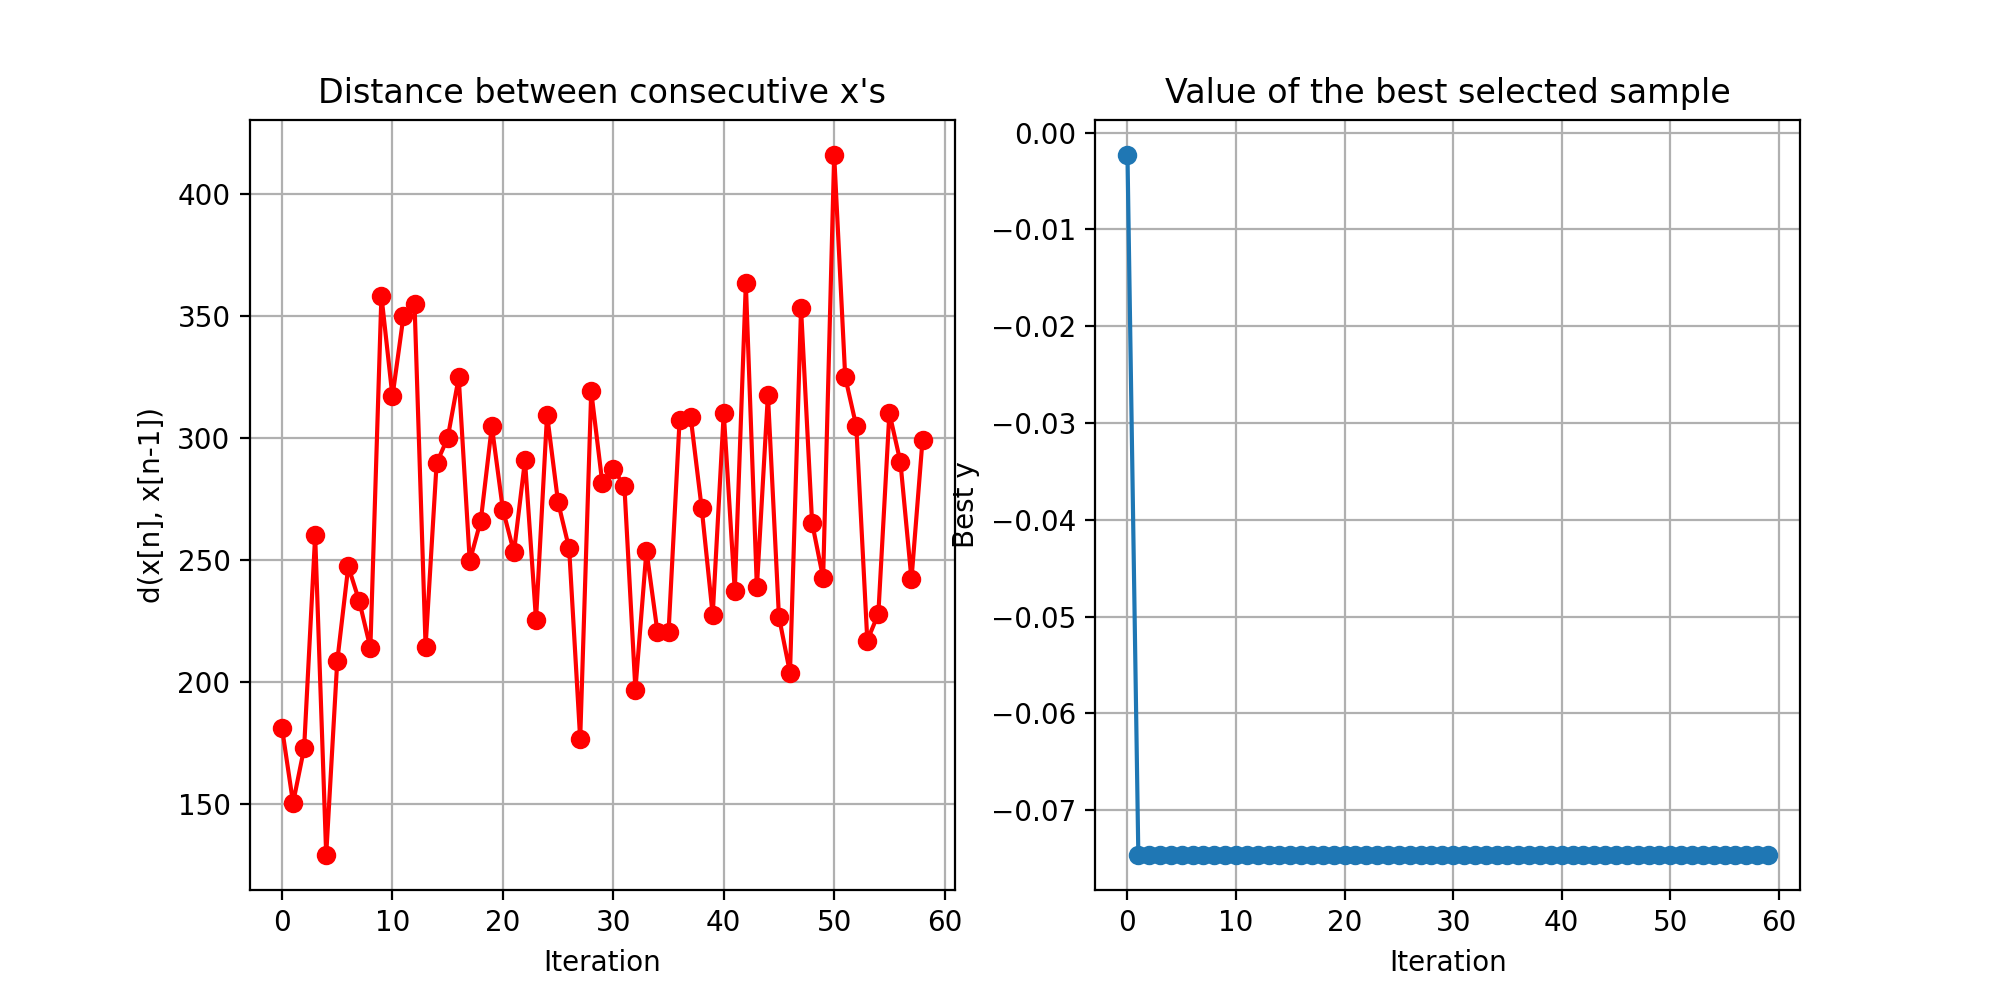

In [50]:
possible_mus = (0, 200)
possible_sigmas = (1e-5, 10e-4)
possible_lowers = tuple([i for i in range(200)])
possible_highers = possible_lowers
domain = [
    {"name": "var_1", "type": "discrete", "domain": (0,1,2)},
    {"name": "var_2", "type": "continuous", "domain": possible_mus},
    {"name": "var_3", "type": "continuous", "domain": possible_sigmas},
    {"name": "var_4", "type": "discrete", "domain": (0,1), "dimensionality": 6},
    {"name": "var_5", "type": "discrete", "domain": possible_lowers, "dimensionality": 6},
    {"name": "var_6", "type": "discrete", "domain": possible_highers, "dimensionality": 6}
]

Bopt = BayesianOptimization(f=f_pymc3, domain=domain,acquisition_type = 'EI',              
                                            normalize_Y = True,
                                            initial_design_numdata = 10,
                                            evaluator_type = 'local_penalization',
                                            acquisition_jitter = 0)
Bopt.run_optimization(max_iter = 50,eps=1e-6)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

In [11]:
I, (trace, model) = f_pymc3(np.asarray([Bopt.x_opt]), return_trace=True)

Sequential sampling (2 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [married_a]
>>Metropolis: [race_a]
>>Metropolis: [educ_a]
>>Metropolis: [sex_a]
>>Metropolis: [age_a]
>>Metropolis: [N]
>NUTS: [income_a]


Sampling 2 chains for 1_000 tune and 3_000 draw iterations (2_000 + 6_000 draws total) took 64 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


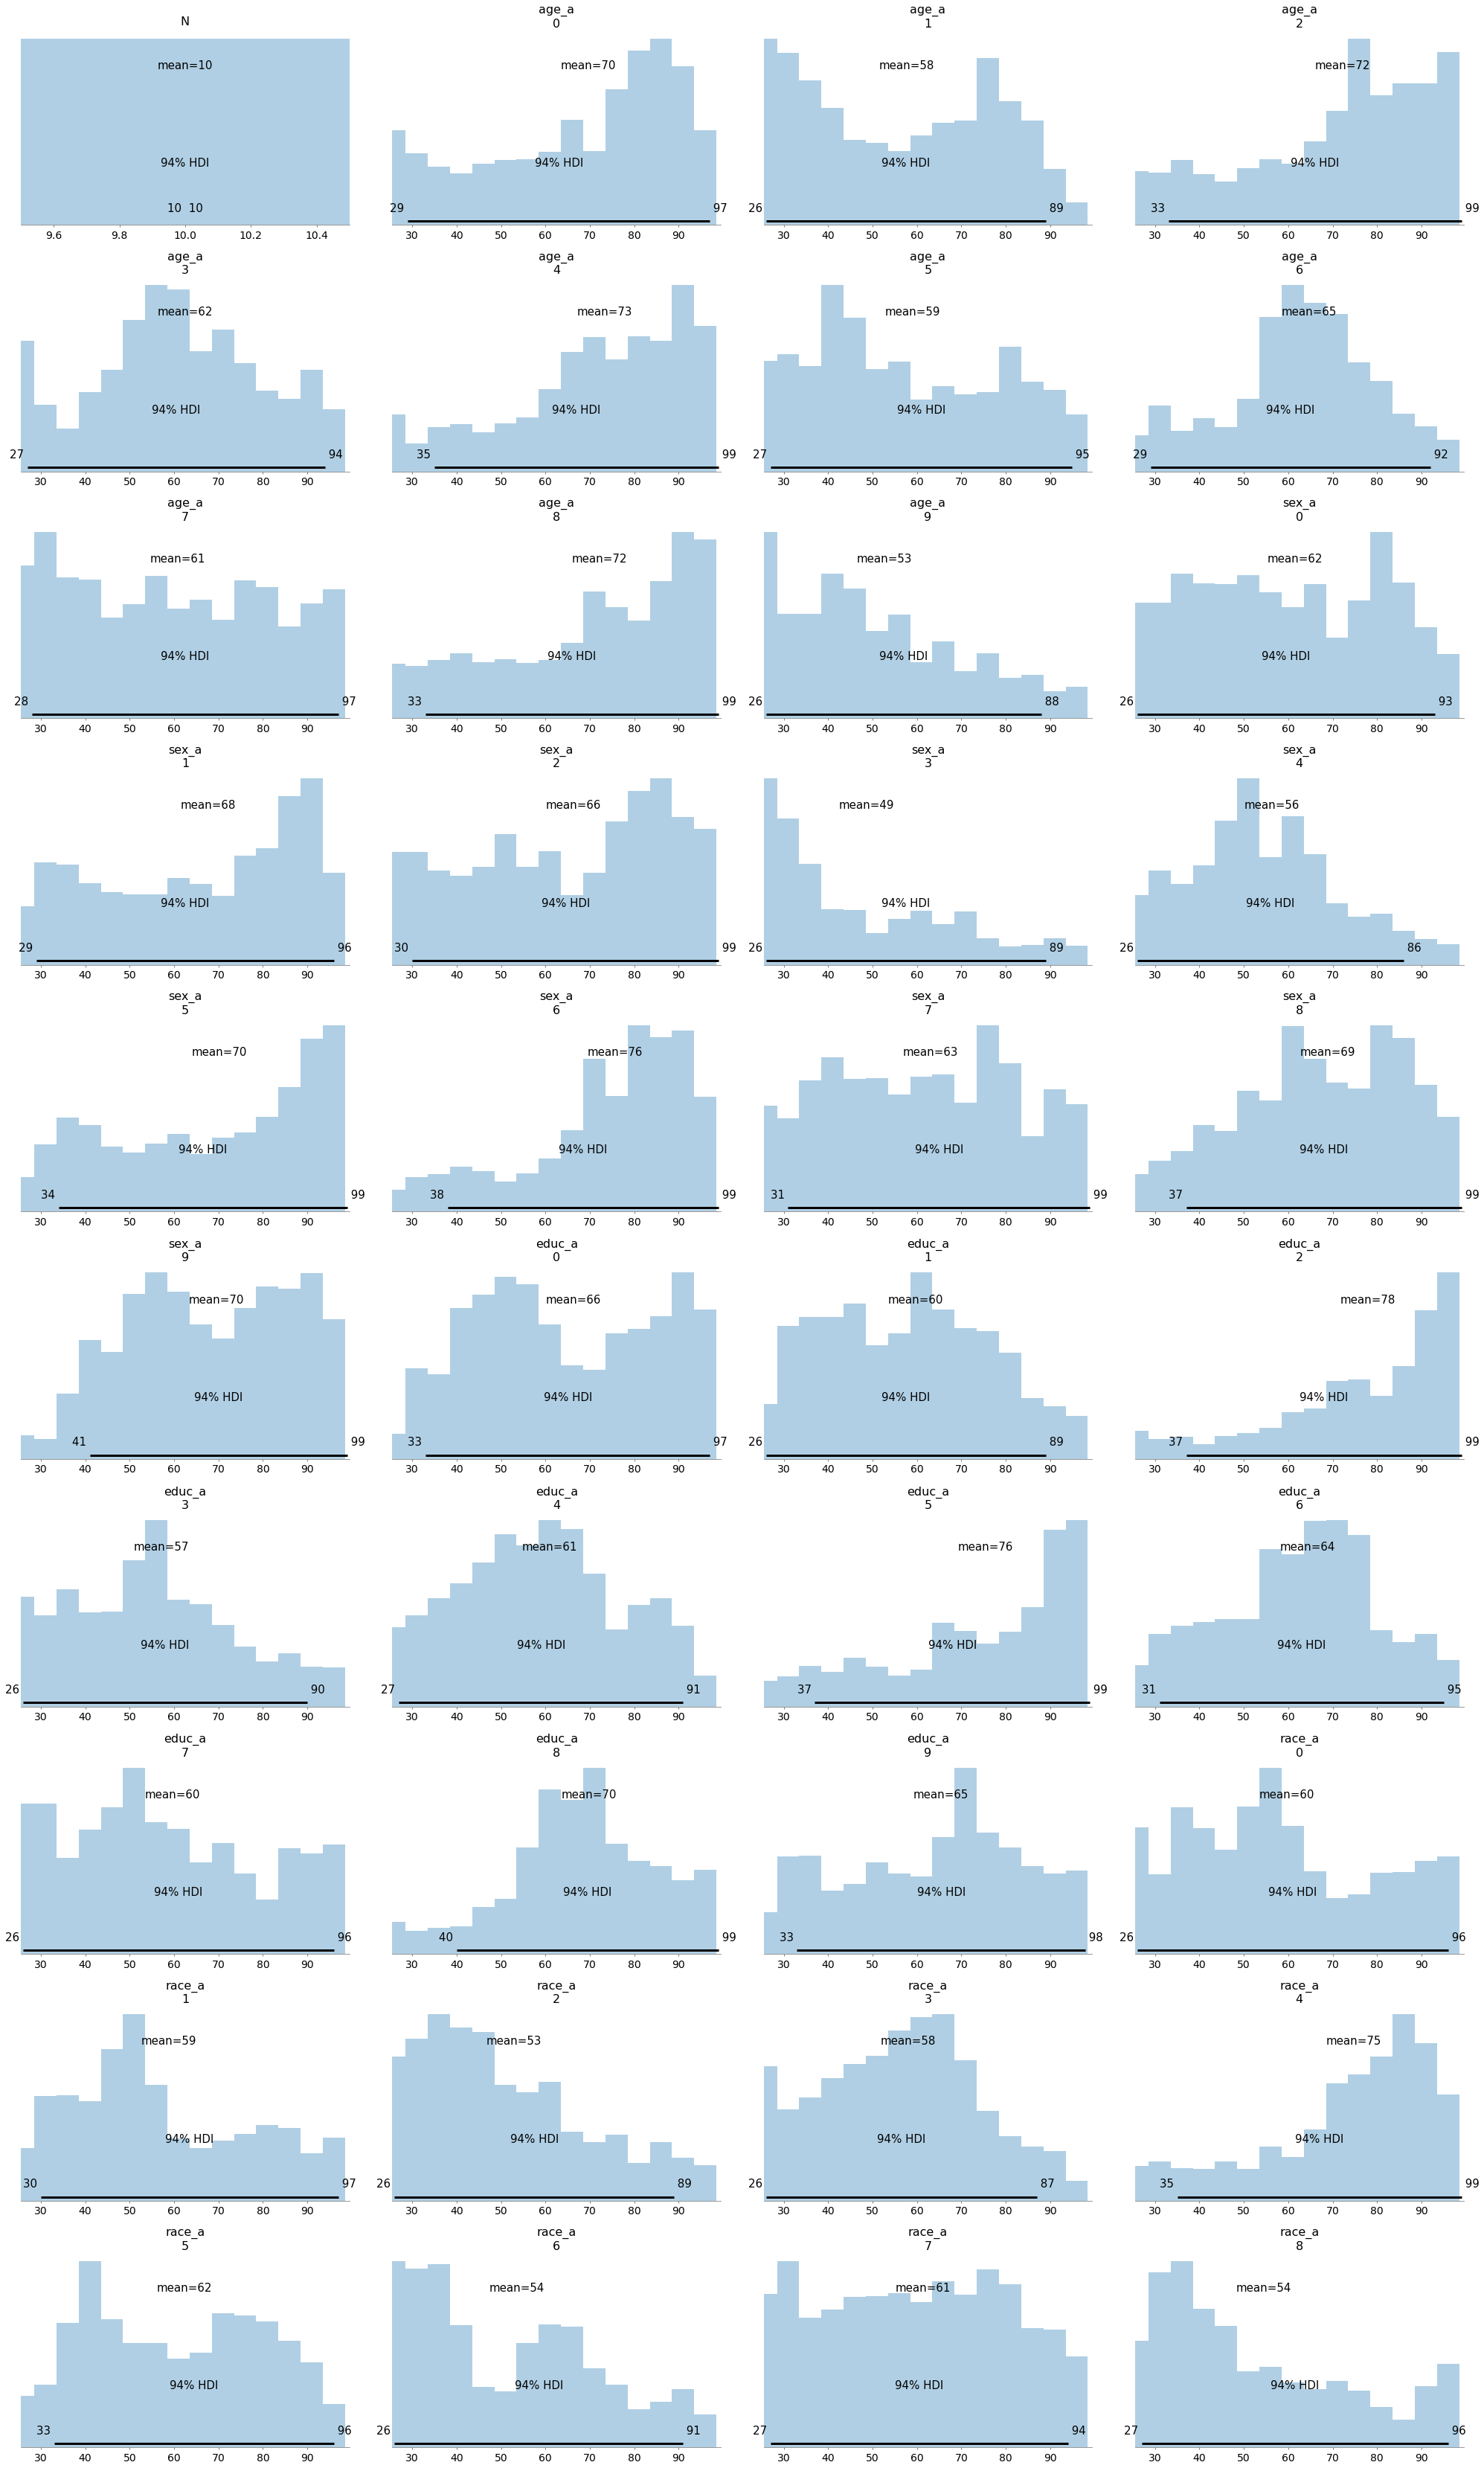

In [12]:
with model:
    az.plot_posterior(trace)

<AxesSubplot:>

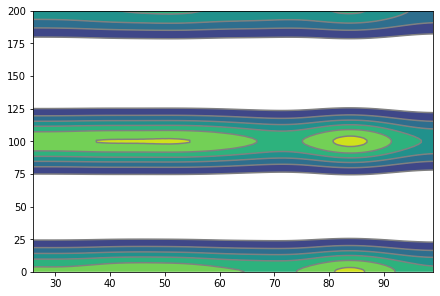

In [15]:
az.plot_kde(trace["sex_a"][:,0], trace["output"])

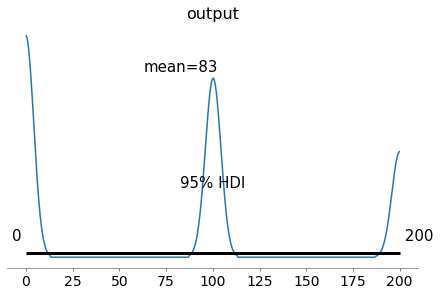

In [14]:
with model:
    az.plot_posterior(trace,var_names=['output'],hdi_prob=.95)

In [20]:
import theano.tensor as tt
with pm.Model() as mudal:
    s = pm.Uniform("test", 0, 100, shape=10)
    out = tt.stack([s[0],s[1]], axis=2)
    pm.sample()
    print(out)

MakeVector{dtype='float64'}.0


In [20]:
import numpy as np
from pyGPGO.covfunc import squaredExponential
from pyGPGO.acquisition import Acquisition
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.GPGO import GPGO

def f(x):
    return (np.sin(x))


sexp = squaredExponential()
gp = GaussianProcess(sexp)
acq = Acquisition(mode='ExpectedImprovement')
param = {'x': ('cont', [0, 2 * np.pi])}

np.random.seed(23)
gpgo = GPGO(gp, acq, f, param)
gpgo.run(max_iter=20)

Evaluation 	 Proposed point 	  Current eval. 	 Best eval.
init   	 [3.25027846]. 	  -0.1084719588823907 	 -0.1084719588823907
init   	 [5.94994152]. 	  -0.32711007941725473 	 -0.1084719588823907
init   	 [4.80952551]. 	  -0.9952859553348876 	 -0.1084719588823907
1      	 [1.58178017]. 	  0.9999396782415523 	 0.9999396782415523
2      	 [0.66932347]. 	  0.6204555671229247 	 0.9999396782415523
3      	 [2.06732055]. 	  0.879243634245828 	 0.9999396782415523
4      	 [0.]. 	  0.0    	 0.9999396782415523
5      	 [1.44115493]. 	  0.9916083166314503 	 0.9999396782415523
6      	 [1.57443681]. 	  0.99999337343526 	 0.99999337343526
7      	 [1.57340324]. 	  0.9999966020119506 	 0.9999966020119506
8      	 [1.57299501]. 	  0.9999975828909311 	 0.9999975828909311
9      	 [1.57277186]. 	  0.9999980486267337 	 0.9999980486267337
10     	 [1.57264093]. 	  0.9999982987182412 	 0.9999982987182412
11     	 [1.5725505]. 	  0.9999984614461296 	 0.9999984614461296
12     	 [1.57248585]. 	  0.999998572

In [22]:
gpgo.GP

In [34]:
def split(a,b):
    return (a, b//2), (b//2, b)

def f(X):
    print(X)
    if x == 1024:
        return 1
    else:
        return 0

domain = [
    {"name": "range", "type": "continuous", "domain": (0,100)},
    {"name": "var_2", "type": "continuous", "domain": (0,100), "dimensionality": 2},
]

Bopt = BayesianOptimization(f=f, domain=domain)
Bopt.run_optimization(max_iter = 10,eps=1e-6)
print("="*20)
print("Value of (x,y) that minimises the objective:"+str(Bopt.x_opt))    
print("Minimum value of the objective: "+str(Bopt.fx_opt))     
print("="*20)
Bopt.plot_convergence()

[[ 1.         87.66388737 29.07998593]]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()